<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/LongShortCointegra%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf

import numpy as np
import pandas as pd

import seaborn
from seaborn.matrix import axis_ticklabels_overlap
import matplotlib.pyplot as plt
from pylab import rcParams
#rcParams['figure.figsize'] = 15, 5

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [2]:
symbols = [
    'RRRP3', 'ENEV3', 'PETR3', 'PETR4', 'PRIO3',
    'UNIP6', 'BRKM5',
    'ABEV3', 'ASAI3', 'CRFB3', 'LREN3', 'MGLU3','PCAR3', 'VIIA3',
    'ARZZ3', 'LREN3', 'MGLU3', 'VIIA3',
    'AZUL4', 'GOLL4', 'CVCB3',
    'BBSE3', 'PSSA3', 'IRBR3',
    'ITSA4', 'ITUB4', 'ITUB3',   
    'B3SA3', 'BPAN4', 'BPAC11', 'BBDC3', 'BBDC4', 'BBAS3', 'CIEL3', 'SANB11',
    'IGTI11','MULT3', 'ALSO3',
    'BRAP4', 'CMIN3', 'GGBR4', 'GOAU4', 'CSNA3','USIM5','VALE3',
    'BRFS3', 'JBSS3', 'MRFG3', 'BEEF3',
    'CCRO3', 'ECOR3',
    'CMIG4', 'CPLE6', 'CPFE3', 'ELET3', 'ELET6', 'ENGI11','EGIE3', 'EQTL3','TAEE11',
    'CYRE3', 'DXCO3', 'EZTC3', 'JHSF3', 'MRVE3',
    'HAPV3', 'HYPE3', 'QUAL3', 'RADL3', 'RDOR3', 'FLRY3',
    'LWSA3', 'POSI3', 'TOTS3', 'SQIA3' , 'VLID3' ,
    'UGPA3', 'VBBR3', 'CSAN3', 'RAIZ4', 
    'RAIL3', 'JSLG3',
    'BOVA11', 'SMAL11', 'MATB11'
    ] 


In [3]:
try:
    dados = pd.read_csv('data/precos.csv',index_col='Date')
except:
     dados = yf.download((pd.Series(symbols)+'.SA').to_list(), period = 'max', auto_adjust=True , progress = False)['Close']
     dados.dropna(inplace=True)
     dados.to_csv('/home/yair/GHub/Codigos-em-financas/precos.csv')
dados.head(3)

dados = dados.apply(np.log)

symbols=dados.keys()

N=int(len(symbols)*(len(symbols)-1)/2)
print(N)
relative_cutoff = 1 * 10 ** (-int(np.log(N)/np.log(10))-1)
print(relative_cutoff)

3321
0.0001


In [4]:
dados.head(3)

,ABEV3.SA,ALSO3.SA,ARZZ3.SA,ASAI3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,...,SQIA3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,UNIP6.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIIA3.SA,VLID3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-22,2.762229,3.036084,4.250837,2.609876,3.303217,2.421819,3.225491,2.655921,2.810877,2.905612,...,2.825942,3.380224,3.475768,2.518946,4.228089,2.422048,4.070359,3.027143,1.742219,1.990793
2021-11-23,2.755277,3.030111,4.220351,2.614939,3.292126,2.411852,3.266452,2.680388,2.830019,2.891768,...,2.802734,3.378246,3.424634,2.567628,4.242016,2.468532,4.096354,3.055173,1.778336,2.011743
2021-11-24,2.749446,3.031493,4.223582,2.604787,3.279406,2.429230,3.284807,2.698216,2.855458,2.896866,...,2.786957,3.389498,3.445713,2.564022,4.206058,2.502762,4.119298,3.040352,1.769855,2.011743


In [5]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def residuos (x,y):
  x = x.values
  y = y.values
  xx = sm.add_constant(x)
  model = sm.OLS(y, xx)
  results = model.fit()
  intercept, slope = results.params
  r_sq = results.rsquared 
  return y -  slope*x , slope , intercept , r_sq 

def estacionaridade(X, cutoff=0.01 ):
     # H_0 é nao-estacionário, i.e., admite raiz unitaria (teste adfuller)    
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' A serie "'+X.name+'" é, provavelmente, estacionaria.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' A serie "'+X.name+'" é, provavelmente, não-estacionaria.')
        return False

def find_cointegrated_pairs(data,cutoff=0.05):
  """
      Para cada par (X,Y) de ativos testa cointegração. ie, estacionariedade de Y - Ŷ  
  """
  n = data.shape[1]
  score_matrix = np.zeros((n, n))
  pvalue_matrix = np.ones((n, n))
  keys = data.keys()
  pairs = []
  for i in range(n):
      for j in range(i+1, n):
          X = data[keys[i]]
          Y = data[keys[j]]
          result = coint(Y,X) # Y dependent
          score = result[0]
          pvalue = result[1]
          score_matrix[i, j] = score
          pvalue_matrix[i, j] = pvalue
          if pvalue < cutoff:
              pairs.append((keys[i], keys[j]))
  return score_matrix, pvalue_matrix, pairs 

def meia_vida (cointegrated_series = np.array([10.2, 11.5, 9.8, 10.9, 10.1, 9.6, 11.0, 10.7, 11.2, 9.9])) :
   # Create lagged series
   lagged_series = np.roll(cointegrated_series, shift=1)
   lagged_series[0] = 0  # Replace the first value with 0

   # Perform OLS regression
   X = sm.add_constant(lagged_series)
   model = sm.OLS(cointegrated_series, X).fit()

   # Get the lambda estimate from the coefficient
   lambda_estimate = -model.params[1]

   half_life = -np.log(2) / lambda_estimate

   return lambda_estimate , half_life


   
def arrange_subplots(xs, ys, n_plots , tt =[]):
  """
  ---- Parameters ----
  xs (n_plots, d): list with n_plot different lists of x values that we wish to plot
  ys (n_plots, d): list with n_plot different lists of y values that we wish to plot
  n_plots (int): the number of desired subplots
  """
  from matplotlib import gridspec
  %matplotlib inline

  # compute the number of rows and columns
  if n_plots<3 : 
    n_cols = 3
    n_rows = 1
  else: 
    n_cols = int(np.sqrt(n_plots))
    n_rows = int(np.ceil(n_plots / n_cols))

  # setup the plot
  gs = gridspec.GridSpec(n_rows, n_cols)
  scale = max(n_cols, n_rows)
  fig = plt.figure(figsize=(.5 * scale, .5 * scale))

  # loop through each subplot and plot values there
  for i in range(n_plots):
    ax = fig.add_subplot(gs[i])
    ax.title.set_text(tt[i])
    ax.plot(xs[i], ys[i])
    plt.axhline(y = 0, color = 'silver', linestyle = '-')
    plt.axhline(y = 1, color = 'orange', linestyle = '-')
    plt.axhline(y = -1, color = 'orange', linestyle = '-')
    plt.axhline(y = 2, color = 'red', linestyle = '-')
    plt.axhline(y = -2, color = 'red', linestyle = '-')

    plt.show()



In [6]:
# # code to check data
# y = dados.iloc[:,0].values.astype(float)
# x = dados.iloc[:,1].values.astype(float)
# print(coint(x,y))
# print(coint(y,x))
# xx = sm.add_constant(x)
# model = sm.OLS(y, xx)
# result = model.fit()
# intercept, slope = result.params
# print(adfuller(y-slope*x))
# print(adfuller(y-(slope*x+intercept)))
# print(adfuller(result.resid))

Examina uma lista de títulos e testa a cointegração entre todos os pares. Ele retorna uma matriz de pontuação de teste de cointegração, uma matriz de valor p e quaisquer pares para os quais o valor p foi inferior ao limiar.

**Isso incorrerá em um grande viés de comparações múltiplas.**

Mtodos para encontrar pares viáveis vivem em um espectro. Num extremo há a formação de uma hipótese económica para um par individual. Você tem algum conhecimento extra sobre um vínculo econômico que o leva a acreditar que o par é cointegrado, então você sai e testa a presença de cointegração. Nesse caso, você não incorrerá em viés de comparações múltiplas. No outro extremo do espectro, você realiza uma pesquisa em centenas de títulos diferentes em busca de pares viáveis de acordo com seu teste. Nesse caso, você incorrerá em um grande viés de comparações múltiplas.

O viés de comparações múltiplas é a maior chance de gerar incorretamente um valor p significativo quando muitos testes são executados. Se 100 testes forem executados em dados aleatórios, devemos esperar ver 5 valores de p abaixo de $0,05$ na média. Como realizaremos comparações $n(n-1)/2$, devemos esperar ver muitos valores p incorretamente significativos. 

Na prática, seria necessário um segundo passo de verificação. Outra abordagem é escolher um pequeno número de pares nos quais há  motivos para suspeitar que possam estar cointegrados e testar cada um individualmente. Isso resultará em menos exposição ao viés de comparações múltiplas. [O viés de comparações múltiplas](https://en.wikipedia.org/wiki/Multiple_comparisons_problem).

In [7]:
scores, pvalues, pairs = find_cointegrated_pairs(dados,.03)#relative_cutoff)
len(pairs)

67

In [8]:
for pp in pairs:
    i = pd.Index(symbols).get_loc(pp[0])
    j = pd.Index(symbols).get_loc(pp[1])
    if (1-pvalues[i,j]) > 0:
        print(f' par {pp}; confiabilidade {(1-pvalues[i,j])*100:.2f}%; score {scores[i,j]}; p-valor {pvalues[i,j]} ')

 par ('ABEV3.SA', 'BRAP4.SA'); confiabilidade 98.87%; score -3.8585018865520184; p-valor 0.011306848023654824 
 par ('ALSO3.SA', 'BOVA11.SA'); confiabilidade 98.10%; score -3.6876319738471346; p-valor 0.019007078334280468 
 par ('ALSO3.SA', 'BRAP4.SA'); confiabilidade 97.02%; score -3.530304955823659; p-valor 0.029801826419569737 
 par ('ALSO3.SA', 'ENGI11.SA'); confiabilidade 98.40%; score -3.746392076624822; p-valor 0.01595529267722755 
 par ('ASAI3.SA', 'BRAP4.SA'); confiabilidade 97.66%; score -3.6159562034927566; p-valor 0.023409427977268343 
 par ('AZUL4.SA', 'BRAP4.SA'); confiabilidade 97.10%; score -3.540042123230243; p-valor 0.029007020327660775 
 par ('AZUL4.SA', 'VBBR3.SA'); confiabilidade 97.28%; score -3.5629689455111255; p-valor 0.027206836502898013 
 par ('B3SA3.SA', 'BOVA11.SA'); confiabilidade 99.99%; score -5.175514936320737; p-valor 7.731631453436709e-05 
 par ('B3SA3.SA', 'ENGI11.SA'); confiabilidade 98.03%; score -3.6760884287886775; p-valor 0.01966317715963768 
 p

In [9]:
pvalues.min()

2.758319451941767e-13

In [10]:
scores[np.unravel_index(scores.argmin(), scores.shape)[0]][np.unravel_index(scores.argmin(), scores.shape)[1]]

-8.803955826632889

In [11]:
print(symbols[np.unravel_index(pvalues.argmin(), pvalues.shape)[0]] 
      , symbols[np.unravel_index(pvalues.argmin(), pvalues.shape)[1]])

BRAP4.SA VALE3.SA


In [12]:
X= dados[symbols[np.unravel_index(scores.argmin(), scores.shape)[0]]]
Y= dados[symbols[np.unravel_index(scores.argmin(), scores.shape)[1]]]
X=dados['BPAC11.SA']
Y=dados['ENGI11.SA']

In [13]:
X=dados['GGBR4.SA']
Y=dados['MRVE3.SA']

In [14]:
# seaborn.set(rc={'figure.figsize':(8,8)})
# seaborn.heatmap(
#     pvalues, 
#     xticklabels=symbols, 
#     yticklabels=symbols, 
#     cmap='RdYlGn_r', 
#     mask = (pvalues >= 0.01)
# )

In [15]:
# # !pip install -qU kaleido
# import kaleido
# import plotly
# plotly.io.renderers.default = 'svg'


In [16]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


In [17]:
trace1 = go.Scatter( x = X.index,  y = X ,
                    name = X.name,
                    line=dict(color='steelblue'))

trace2 = go.Scatter( x = Y.index,  y = Y ,
                    name = Y.name , 
                    line=dict(color='lightgreen'))

fig = go.Figure(data=[trace1,trace2] )

fig.show()

In [18]:


trace1 = go.Scatter( x = X.index,  y= zscore(residuos(x=X,y=Y)[0]) , 
                    name = 'resíduo (spread)',
                    line=dict(color='steelblue'))

trace2 = go.Scatter( x = Y.index,  y = zscore(X/Y) , 
                    name = 'Ratio '+X.name+'/'+Y.name,
                    line=dict(color='steelblue'))

fig = make_subplots(rows=2, cols=1,subplot_titles=(['z-score do residuo','z-score do ratio dos preços']))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(shapes=[{'type': 'line','y0':1,'y1': 1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':-1,'y1': -1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':2,'y1': 2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':-2,'y1': -2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':0,'y1': 0,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'black','width': 1,'dash':'dash'}},
                             {'type': 'line','y0':0,'y1': 0,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'black','width': 1,'dash':'dash'}},
                             {'type': 'line','y0':1,'y1': 1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':-1,'y1': -1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':2,'y1': 2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':-2,'y1': -2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'red','width': 1}}
                             ],title='Para o par ('+X.name+','+Y.name+')')
fig.show()

In [19]:
zscore(X/Y)

Date
2021-11-22   -0.874812
2021-11-23   -0.863328
2021-11-24   -0.808208
2021-11-25   -0.905422
2021-11-26   -0.834150
                ...   
2023-08-14   -0.826443
2023-08-15   -0.864933
2023-08-16   -0.831183
2023-08-17   -0.770726
2023-08-18   -0.845065
Length: 436, dtype: float64

In [20]:
residuos(x=X,y=Y)[0]

array([3.78776222, 3.79136821, 3.79370725, 3.83743693, 3.78032365,
       3.7751308 , 3.75991807, 3.74650348, 3.81722944, 3.87183854,
       3.8933709 , 3.86937547, 3.92616445, 3.87883799, 3.94072934,
       3.92063332, 3.88816339, 3.89496023, 3.89447593, 3.88065663,
       3.83410227, 3.83559283, 3.83033612, 3.81952231, 3.84726566,
       3.85732639, 3.85376276, 3.87789101, 3.81867167, 3.79276237,
       3.74489566, 3.74601672, 3.75484123, 3.74501423, 3.76487778,
       3.80994658, 3.80233075, 3.81611332, 3.79765471, 3.79113825,
       3.84188246, 3.88388996, 3.88461859, 3.88534612, 3.92332274,
       3.97376345, 4.00746638, 3.99210885, 3.99877689, 3.99687091,
       3.9766357 , 3.97927976, 3.94074434, 3.93780518, 3.93137998,
       3.93848588, 3.91257536, 3.90013965, 3.90484677, 3.93521039,
       3.94174598, 3.89251559, 3.91133514, 3.86188533, 3.87700483,
       3.85388364, 3.82903501, 3.84194376, 3.85580026, 3.88272615,
       3.8756848 , 3.82210335, 3.81338793, 3.93234437, 3.91687

In [21]:
trades = pd.DataFrame()
trades['zscore'] = zscore(X/Y)
# trades['zscore'] = zscore(Y-X)

trades['posicao']= residuos(x=X,y=Y)[0]
# trades.columns = ["sinal", "posicao"]
trades

,zscore,posicao
Date,,
2021-11-22,-0.874812,3.787762
2021-11-23,-0.863328,3.791368
2021-11-24,-0.808208,3.793707
2021-11-25,-0.905422,3.837437
2021-11-26,-0.834150,3.780324
...,...,...
2023-08-14,-0.826443,4.050877
2023-08-15,-0.864933,4.061483
2023-08-16,-0.831183,4.048651


### Comprando o par
É quando o spread é pequeno e esperamos que aumente. Apostamos nisso comprando Y e vendendo X.

### Vendendo o par
É quando o spread é grande e esperamos que diminua. Apostamos nisso vendendo Y e desejando X.

In [22]:
trades["acao"] = 0
trades.loc[trades.zscore <-1, "acao"] = 1  # compra par
trades.loc[trades.zscore > 1, "acao"] = -1  # vende par
trades[trades.acao != 0]

,zscore,posicao,acao
Date,,,
2022-01-26,-1.075974,3.973763,1
2022-01-27,-1.158430,4.007466,1
2022-01-28,-1.102648,3.992109,1
2022-01-31,-1.149884,3.998777,1
2022-02-01,-1.033479,3.996871,1
...,...,...,...
2023-04-27,1.140744,3.426112,-1
2023-04-28,1.148616,3.456793,-1
2023-05-02,1.193565,3.414558,-1


In [23]:
trades['pos1'] = trades['acao'].diff()
trades['oaca'] = -trades['acao']
trades['pos2'] = trades['oaca'].diff()
trades

,zscore,posicao,acao,pos1,oaca,pos2
Date,,,,,,
2021-11-22,-0.874812,3.787762,0,NaN,0,NaN
2021-11-23,-0.863328,3.791368,0,0.0,0,0.0
2021-11-24,-0.808208,3.793707,0,0.0,0,0.0
2021-11-25,-0.905422,3.837437,0,0.0,0,0.0
2021-11-26,-0.834150,3.780324,0,0.0,0,0.0
...,...,...,...,...,...,...
2023-08-14,-0.826443,4.050877,0,0.0,0,0.0
2023-08-15,-0.864933,4.061483,0,0.0,0,0.0
2023-08-16,-0.831183,4.048651,0,0.0,0,0.0


In [24]:
C0 = 1000

CX = C0 // max(X)
CY =  C0 //max(Y)

portfolio = pd.DataFrame()

portfolio[X.name] = X
# portfolio['Hold '+X.name] 

portfolio[Y.name] = Y



<Axes: xlabel='Date'>

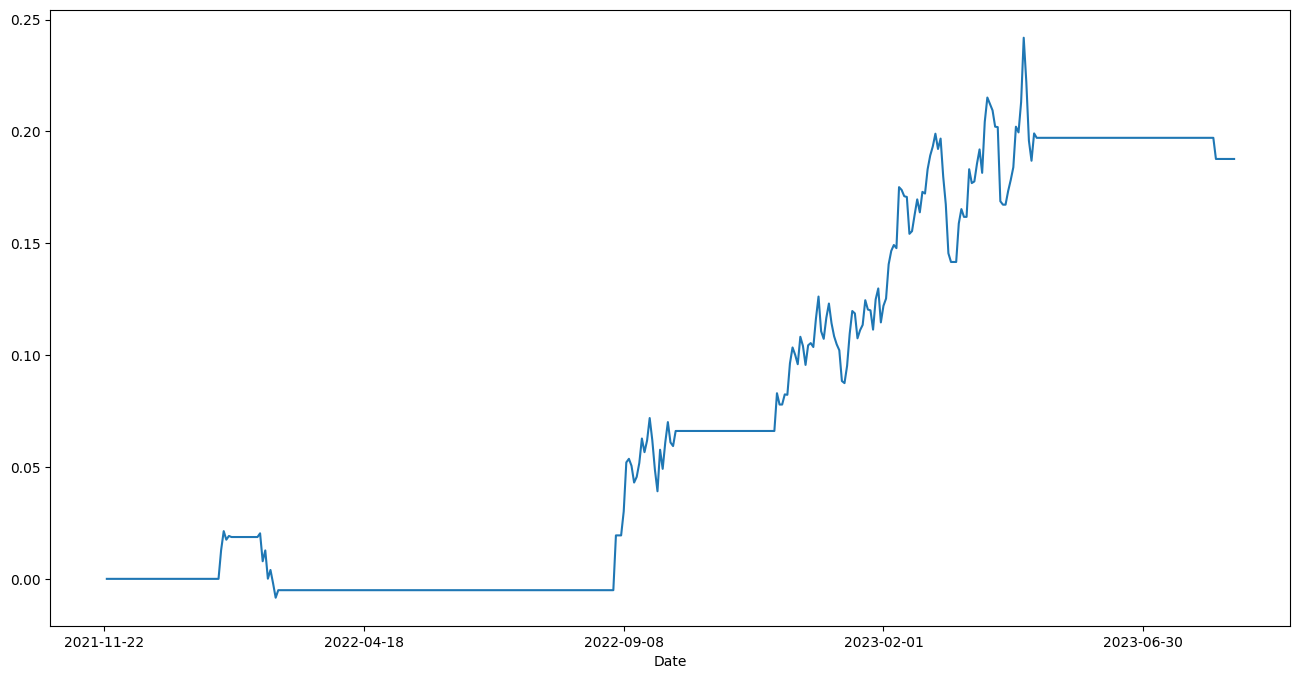

In [25]:
retornos = trades.posicao.pct_change() * trades.acao
retornos.cumsum().plot(figsize=(16,8))